# Create synthetic ground and airborne surveys from a synthetic model

**Import useful packages**

In [1]:
from IPython.display import display
from pathlib import Path
import pyproj
import numpy as np
import xarray as xr
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

from boost_and_layouts import (
    synthetic_model,
    save_to_json,
)


**Define parameters**

In [2]:
# Define results directories
results_dir = Path("..") / "results"
ground_results_dir = results_dir / "ground_survey"
airborne_results_dir = results_dir / "airborne_survey"

# Define a survey region of 1 x 1 degrees (~ 100km x 100km)
region_degrees = (-0.5, 0.5, -0.5, 0.5)

# Define bottom and top of the synthetic model
model_bottom, model_top = -10e3, 0

# Define which field will be meassured
field = "g_z"
field_units = "mGal"

# Define standard deviation for the Gaussian noise that
# will be added to the synthetic survey (in mGal)
noise_std = 1

# Define a seed to reproduce the same results on each run
np.random.seed(12345)

# Define the spacing of the target regular grid
# and its observation height
target_grid_spacing = 2e3
target_grid_height = 2000

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Synthetic model made out of prisms

Project region coordinates to get synthetic model boundaries

In [3]:
projection = pyproj.Proj(proj="merc", lat_ts=0)
easting, northing = projection(region_degrees[:2], region_degrees[2:])

# Define region and model_region
region = (min(easting), max(easting), min(northing), max(northing))
model_region = tuple(list(region) + [model_bottom, model_top])

Create synthetic model

In [4]:
model = synthetic_model(model_region)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


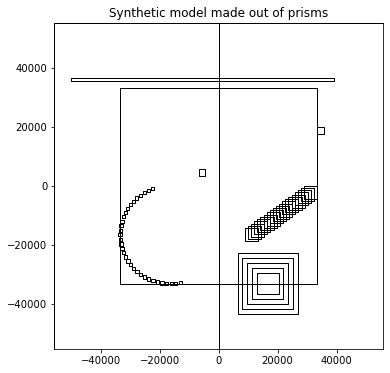

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_collection(PatchCollection(model["rectangles"], match_original=True))
ax.set_aspect("equal")
ax.set_title("Synthetic model made out of prisms")
ax.set_xlim(region[:2])
ax.set_ylim(region[2:4])
plt.show()

**Save model related quantities on dictionary**

In [6]:
variables = {
    "n_prisms": len(model["densities"]),
    "model_easting": (model_region[1] - model_region[0]),
    "model_northing": (model_region[1] - model_region[0]),
    "model_depth": abs(model_region[4]),
    "model_min_density": np.min(model["densities"]),
    "model_max_density": np.max(model["densities"]),
}

## Synthetic ground survey

Get coordinates of observation points

In [7]:
survey = hm.synthetic.ground_survey(region=region_degrees)
display(survey)

,longitude,latitude,height
11033,-0.151685,-0.480089,1091.5
11034,-0.147191,-0.492534,1076.2
11066,0.090262,-0.495021,1222.2
11068,0.098003,-0.480089,1228.6
11070,0.108739,-0.472872,1232.9
...,...,...,...
14543,0.420100,0.435789,1097.3
14544,0.440075,0.440766,1069.8
14545,0.460049,0.438278,1061.6
14546,0.481273,0.438278,1063.7


Project observation points

In [8]:
survey["easting"], survey["northing"] = projection(
    survey.longitude.values, survey.latitude.values
)
display(survey)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,longitude,latitude,height,easting,northing
11033,-0.151685,-0.480089,1091.5,-16885.540738,-53086.080028
11034,-0.147191,-0.492534,1076.2,-16385.228420,-54462.226167
11066,0.090262,-0.495021,1222.2,10047.939057,-54737.323605
11068,0.098003,-0.480089,1228.6,10909.643639,-53086.080028
11070,0.108739,-0.472872,1232.9,12104.722997,-52288.035325
...,...,...,...,...,...
14543,0.420100,0.435789,1097.3,46765.359775,48187.521896
14544,0.440075,0.440766,1069.8,48988.914488,48737.877503
14545,0.460049,0.438278,1061.6,51212.469200,48462.782215
14546,0.481273,0.438278,1063.7,53575.110738,48462.782215


Plot the survey points

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


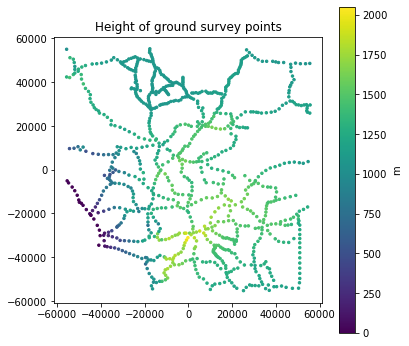

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=survey.height, s=6)
plt.colorbar(tmp, ax=ax, label="m")
ax.set_aspect("equal")
ax.set_title("Height of ground survey points")
plt.show()

Compute gravitational field of synthetic model on ground survey

In [10]:
coordinates = (survey.easting, survey.northing, survey.height)
survey[field] = hm.prism_gravity(
    coordinates, model["prisms"], model["densities"], field=field
) + np.random.normal(scale=noise_std, size=survey.easting.size)
display(survey)

,longitude,latitude,height,easting,northing,g_z
11033,-0.151685,-0.480089,1091.5,-16885.540738,-53086.080028,6.368816
11034,-0.147191,-0.492534,1076.2,-16385.228420,-54462.226167,6.489248
11066,0.090262,-0.495021,1222.2,10047.939057,-54737.323605,5.131214
11068,0.098003,-0.480089,1228.6,10909.643639,-53086.080028,5.660173
11070,0.108739,-0.472872,1232.9,12104.722997,-52288.035325,8.411492
...,...,...,...,...,...,...
14543,0.420100,0.435789,1097.3,46765.359775,48187.521896,6.210351
14544,0.440075,0.440766,1069.8,48988.914488,48737.877503,5.023080
14545,0.460049,0.438278,1061.6,51212.469200,48462.782215,5.163479
14546,0.481273,0.438278,1063.7,53575.110738,48462.782215,4.241533


Plot survey points and observed gravity field

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


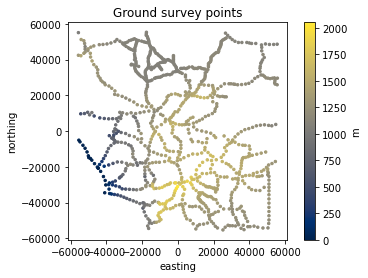

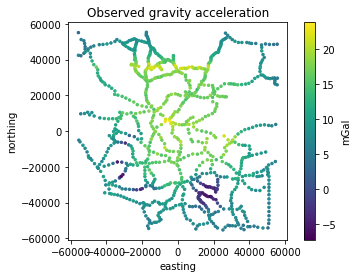

In [11]:
size = 6

plt.scatter(survey.easting, survey.northing, c=survey.height, cmap="cividis", s=size)
plt.colorbar(label="m")
plt.gca().set_aspect("equal")
plt.xlabel("easting")
plt.ylabel("northing")
plt.title("Ground survey points")
plt.show()

plt.scatter(survey.easting, survey.northing, c=survey.g_z, cmap="viridis", s=size)
plt.colorbar(label="mGal")
plt.gca().set_aspect("equal")
plt.xlabel("easting")
plt.ylabel("northing")
plt.title("Observed gravity acceleration")
plt.show()

Save ground survey for future usage

In [12]:
survey.to_csv(ground_results_dir / "survey.csv", index=False)

Save ground survey quantities to LaTeX file

In [13]:
variables["survey_easting"] = region[1] - region[0]
variables["survey_northing"] = region[3] - region[2]
variables["survey_noise"] = noise_std
variables["ground_survey_points"] = int(survey.height.size)
variables["ground_survey_min_height"] = survey.height.min()
variables["ground_survey_max_height"] = survey.height.max()

## Synthetic airborne survey

Get coordinates of observation points

In [14]:
survey = hm.synthetic.airborne_survey(region=region_degrees)
display(survey)

,longitude,latitude,height
140691,-0.496429,0.497339,633.0
140692,-0.495559,0.497999,644.0
140693,-0.493218,0.497479,646.0
140694,-0.482725,0.497679,663.0
140695,-0.478464,0.497719,672.0
...,...,...,...
383610,-0.416257,0.155824,1070.0
383611,-0.258422,0.271476,1087.0
383612,-0.258652,0.277958,1126.0
383613,-0.258983,0.287360,1106.0


Project observation points

In [15]:
survey["easting"], survey["northing"] = projection(
    survey.longitude.values, survey.latitude.values
)
display(survey)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,longitude,latitude,height,easting,northing
140691,-0.496429,0.497339,633.0,-55262.223508,54993.627800
140692,-0.495559,0.497999,644.0,-55165.348426,55066.630053
140693,-0.493218,0.497479,646.0,-54904.787861,55009.113126
140694,-0.482725,0.497679,663.0,-53736.719343,55031.235020
140695,-0.478464,0.497719,672.0,-53262.365493,55035.659399
...,...,...,...,...,...
383610,-0.416257,0.155824,1070.0,-46337.467390,17230.106636
383611,-0.258422,0.271476,1087.0,-28767.445331,30018.377395
383612,-0.258652,0.277958,1126.0,-28793.055985,30735.107734
383613,-0.258983,0.287360,1106.0,-28829.801706,31774.809862


Plot the survey points

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


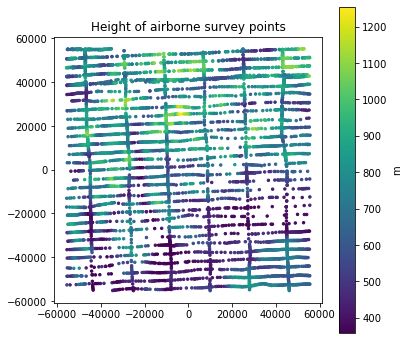

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=survey.height, s=6)
plt.colorbar(tmp, ax=ax, label="m")
ax.set_aspect("equal")
ax.set_title("Height of airborne survey points")
plt.show()

Compute gravitational field of synthetic model on airborne survey

In [17]:
coordinates = (survey.easting, survey.northing, survey.height)
survey[field] = hm.prism_gravity(
    coordinates, model["prisms"], model["densities"], field=field
) + np.random.normal(scale=noise_std, size=survey.easting.size)
display(survey)

,longitude,latitude,height,easting,northing,g_z
140691,-0.496429,0.497339,633.0,-55262.223508,54993.627800,3.654625
140692,-0.495559,0.497999,644.0,-55165.348426,55066.630053,2.503813
140693,-0.493218,0.497479,646.0,-54904.787861,55009.113126,2.873545
140694,-0.482725,0.497679,663.0,-53736.719343,55031.235020,3.125810
140695,-0.478464,0.497719,672.0,-53262.365493,55035.659399,4.717045
...,...,...,...,...,...,...
383610,-0.416257,0.155824,1070.0,-46337.467390,17230.106636,10.041573
383611,-0.258422,0.271476,1087.0,-28767.445331,30018.377395,15.431621
383612,-0.258652,0.277958,1126.0,-28793.055985,30735.107734,14.078125
383613,-0.258983,0.287360,1106.0,-28829.801706,31774.809862,15.672714


Plot survey points and observed gravity field

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


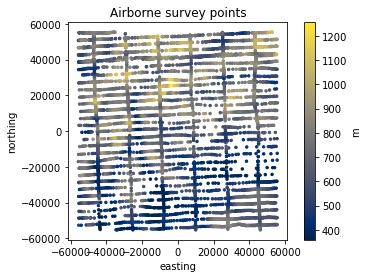

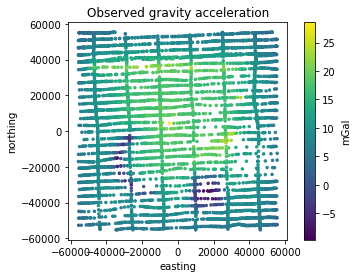

In [18]:
size = 6

plt.scatter(survey.easting, survey.northing, c=survey.height, cmap="cividis", s=size)
plt.colorbar(label="m")
plt.gca().set_aspect("equal")
plt.xlabel("easting")
plt.ylabel("northing")
plt.title("Airborne survey points")
plt.show()

plt.scatter(survey.easting, survey.northing, c=survey.g_z, cmap="viridis", s=size)
plt.colorbar(label="mGal")
plt.gca().set_aspect("equal")
plt.xlabel("easting")
plt.ylabel("northing")
plt.title("Observed gravity acceleration")
plt.show()

Save ground survey for future usage

In [19]:
survey.to_csv(airborne_results_dir / "survey.csv", index=False)

Save airborne survey quantities to variables dictionary

In [20]:
variables["airborne_survey_points"] = int(survey.height.size)
variables["airborne_survey_min_height"] = survey.height.min()
variables["airborne_survey_max_height"] = survey.height.max()

## Compute gravity field on target grid

We want to compute the true gravitational effect generated by the synthetic model on
a regular grid at a constant height.

In [21]:
grid = vd.grid_coordinates(
    region=region,
    spacing=target_grid_spacing,
    adjust="region",
    extra_coords=target_grid_height,
)

Compute gravity field on the grid

In [22]:
target = hm.prism_gravity(grid, model["prisms"], model["densities"], field=field)

Create a xarray.DataArray for the grid

In [23]:
dims = ("northing", "easting")
coords = {"northing": grid[1][:, 0], "easting": grid[0][0, :]}
target = xr.DataArray(
    target, dims=dims, coords=coords, attrs={"height": target_grid_height}
)

Save target grid to disk for future usage

In [24]:
target.to_netcdf(results_dir / "target.nc")

Save target grid quantities to variables dictionary

In [25]:
variables["target_height"] = target_grid_height
variables["target_spacing"] = target_grid_spacing * 1e-3
variables["target_easting_size"] = target.easting.size
variables["target_northing_size"] = target.northing.size

Plot target grid

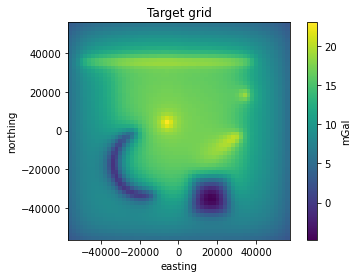

In [26]:
target.plot(center=False, cbar_kwargs={"label": "mGal"})
plt.gca().set_aspect("equal")
plt.title("Target grid")
plt.show()

## Dump variables dictionary to a JSON file

In [27]:
json_file = results_dir / "synthetic-surveys.json"
save_to_json(variables, json_file)